Lets look at the "sensitivity" equation of a SDE instead of a ODE (we aren't sure if taking derivatives of SDE works):
$$
\begin{align*}
dX_t &= (1+\sigma X_{t})dW_{t} \\
d(\partial_{\sigma}X_{t}) &= (X_{t}+ \sigma\partial_{\sigma}X_{t} ) dW_t
\end{align*}
$$ 
with $X_{0} = 0$. Lets first simulate the first SDE with the Euler sheme:
$$
\begin{align*}
dX_t &= (1+\sigma X_{t})dW_{t} \Leftrightarrow \\
X_{t}&= X_{T} + \int_{T}^{t} (1 + \sigma X_{s})dW_{s} \\ 
 &\approx X_{T} + \int_{T}^{t} (1 + \sigma X_{T})dW_{s} \\ 
 &\approx X_{T} + (1 + \sigma X_{T})\int_{T}^{t} dW_{s} \\ 
 &\approx X_{T} + (1 + \sigma X_{T}) N(0,t-T)  
\end{align*}
.
$$ 
  

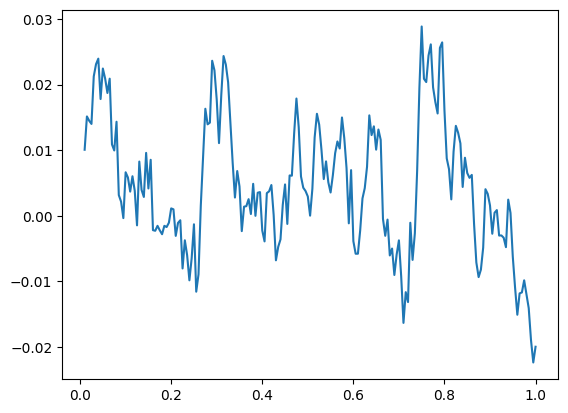

In [76]:
from numpy.random import normal as N
import matplotlib.pyplot as plt

m = []
def X(t,DT,sig=1):
    if t-DT<=0: return N(0,t)
    XT= X(t-DT,DT,sig)
    Xt  = XT + (1 + sig *XT)*N(0,DT)
    m.append((t,Xt))
    return Xt
X(1,0.005)

x,y =zip(*m)
plt.plot(x,y)
plt.show()

Now also use Euler on the sensitivity equation:
$$
\begin{align*}
d(\partial_{\sigma}X_{t}) &= (X_{t}+ \sigma\partial_{\sigma}X_{t} ) dW_t \Leftrightarrow\\
\partial_{\sigma}X_{t} &= \partial_{\sigma}X_{T} +\int_{T}^{t} (X_{s}+ \sigma\partial_{\sigma}X_{s} ) dW_s \\
& \approx \partial_{\sigma}X_{T} +\int_{T}^{t} (X_{T}+ \sigma\partial_{\sigma}X_{T} ) dW_s \\
& \approx \partial_{\sigma}X_{T} +(X_{T}+ \sigma\partial_{\sigma}X_{T} )\int_{T}^{t}  dW_s \\
& \approx \partial_{\sigma}X_{T} +(X_{T}+ \sigma\partial_{\sigma}X_{T} )N(0,t-T) 
\end{align*}
.
$$ 
we implement this by coupling it to the Euler scheme of the solution. We aren't sure that coupling works in this case.


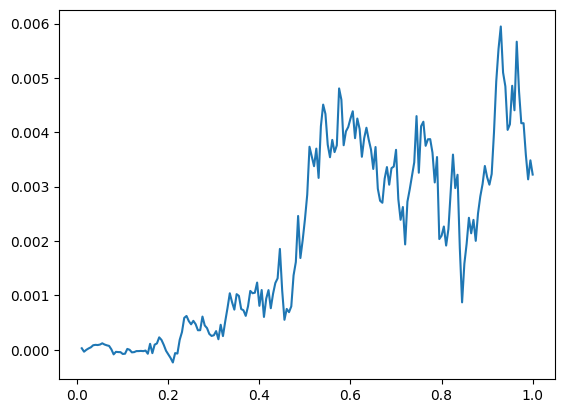

In [145]:
from numpy.random import normal as N
import matplotlib.pyplot as plt

m = []
def E(t,DT,sig=1):
    if t-DT<=0: return (N(0,t),0)
    XT,dXT= E(t-DT,DT,sig)
    Xt = XT + (1 + sig *XT)*N(0,DT)
    dXt = dXT + (XT+ sig*dXT)*N(0,DT) 
    m.append((t,dXt))
    return (Xt,dXt) 

E(1,0.005)
x,y =zip(*m)
plt.plot(x,y)
plt.show()

We will do some testing here